# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import copy
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split

# Preprocessing

In [2]:
data = pd.read_csv('/kaggle/input/Input/train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
data.isnull().values.any()

False

In [5]:
y = data['label']
data.drop('label', axis=1, inplace=True)
X = pd.get_dummies(data, drop_first=True).to_numpy().reshape((-1, 1, 28, 28))

In [6]:
X_train, y_train = X, y
print(X_train.shape)
print(y_train.shape)

(42000, 1, 28, 28)
(42000,)


# Split data 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Creating Dataset & DataLoader

In [9]:
class MNIST_Set(Dataset):
    def __init__(self, numpy_data, labels):
        self.data = numpy_data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return torch.from_numpy(self.data[index]).type(torch.FloatTensor), torch.tensor(self.labels[index])

In [10]:
train_set = MNIST_Set(X_train, y_train)
val_set = MNIST_Set(X_val, y_val)
test_set = MNIST_Set(X_test, y_test)

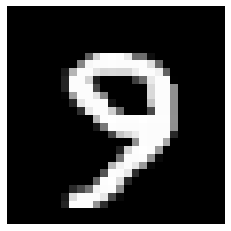

In [11]:
data, label = train_set[1]
plt.imshow(data[0], cmap='gray')

plt.axis("off")
plt.show()

In [12]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

# Model

In [13]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

## Train

In [14]:
model = VGG16(10)
model = model.cuda()
model.train()
epochs = 100

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for i in range(epochs):
    loss = 0
    val_loss = 0
    correct = 0
    val_correct = 0
    
    for j, batch in enumerate(train_loader):
        X, labels = batch[0].cuda(), batch[1].cuda()
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            y = model(X)
            loss = criterion(y, labels)

            loss.backward()
            optimizer.step()
                    
            loss += loss.item() * X.shape[0]
            correct += (y.argmax(1) == labels).float().sum()
    
    with torch.no_grad():
        for j, batch in enumerate(val_loader):
            X, labels = batch[0].cuda(), batch[1].cuda()
            y = model(X)
            val_loss = criterion(y, labels)
            val_loss += val_loss.item() * X.shape[0]
            val_correct += (y.argmax(1) == labels).float().sum()

    acc = float(correct) / float(len(train_set))
    loss = float(loss) / float(len(train_set))

    val_acc = float(val_correct) / float(len(val_set))
    val_loss = float(val_loss) / float(len(val_set))
    
    print("Epoch {}: loss: {} acc: {} val_loss: {} val_acc: {}".format(i + 1, loss, acc, val_loss, val_acc))

    if best_acc < acc:
        best_acc = acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('Model Saved!')

model.load_state_dict(best_model_wts)
print('Model\'s Acc: {}'.format(best_acc))

Epoch 1: loss: 0.000175479782690305 acc: 0.9318833415719229 val_loss: 0.0008725816350913738 val_acc: 0.9660130718954248
Model Saved!
Epoch 2: loss: 0.00012340423871862337 acc: 0.9747899159663865 val_loss: 0.00048049482422159943 val_acc: 0.9714285714285714
Model Saved!
Epoch 3: loss: 0.00013802976697845383 acc: 0.9788103476684792 val_loss: 9.575037061333322e-05 val_acc: 0.9772175536881419
Model Saved!
Epoch 4: loss: 1.4022407627592843e-06 acc: 0.9823364639973636 val_loss: 5.658336477675914e-06 val_acc: 0.9803921568627451
Model Saved!
Epoch 5: loss: 0.0003054627163796355 acc: 0.9855000823858955 val_loss: 6.635718875461154e-05 val_acc: 0.9811391223155929
Model Saved!
Epoch 6: loss: 3.3577025417913065e-07 acc: 0.9863898500576701 val_loss: 3.2318603981331506e-05 val_acc: 0.9837535014005602
Model Saved!
Epoch 7: loss: 2.0954805500111759e-07 acc: 0.9866534849233811 val_loss: 4.442675816578691e-06 val_acc: 0.984313725490196
Model Saved!
Epoch 8: loss: 2.6769735487471067e-05 acc: 0.988531883341

## Test

In [15]:
model.eval()
test_correct = 0
for i, batch in enumerate(test_loader):
    X, labels = batch[0].cuda(), batch[1].cuda()
    y = model(X)
    test_correct += (y.argmax(1) == labels).float().sum()
test_acc = float(test_correct) / float(len(test_set))
print("Test Accuracy: {}".format(test_acc))

Test Accuracy: 0.9934920634920635


# Save the model

In [16]:
model = model.cpu()
torch.save(model.state_dict(), 'model.pt')